In [1]:
from bankingSystem import * 
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# simulation and data collection 
model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", targetLeverageRatio = 11.0, num_borrowing = 2, num_banks = 100)
simulationSteps = 10000
for i in tqdm(range(simulationSteps)):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

100%|██████████| 10000/10000 [02:17<00:00, 72.57it/s]


Step:  0


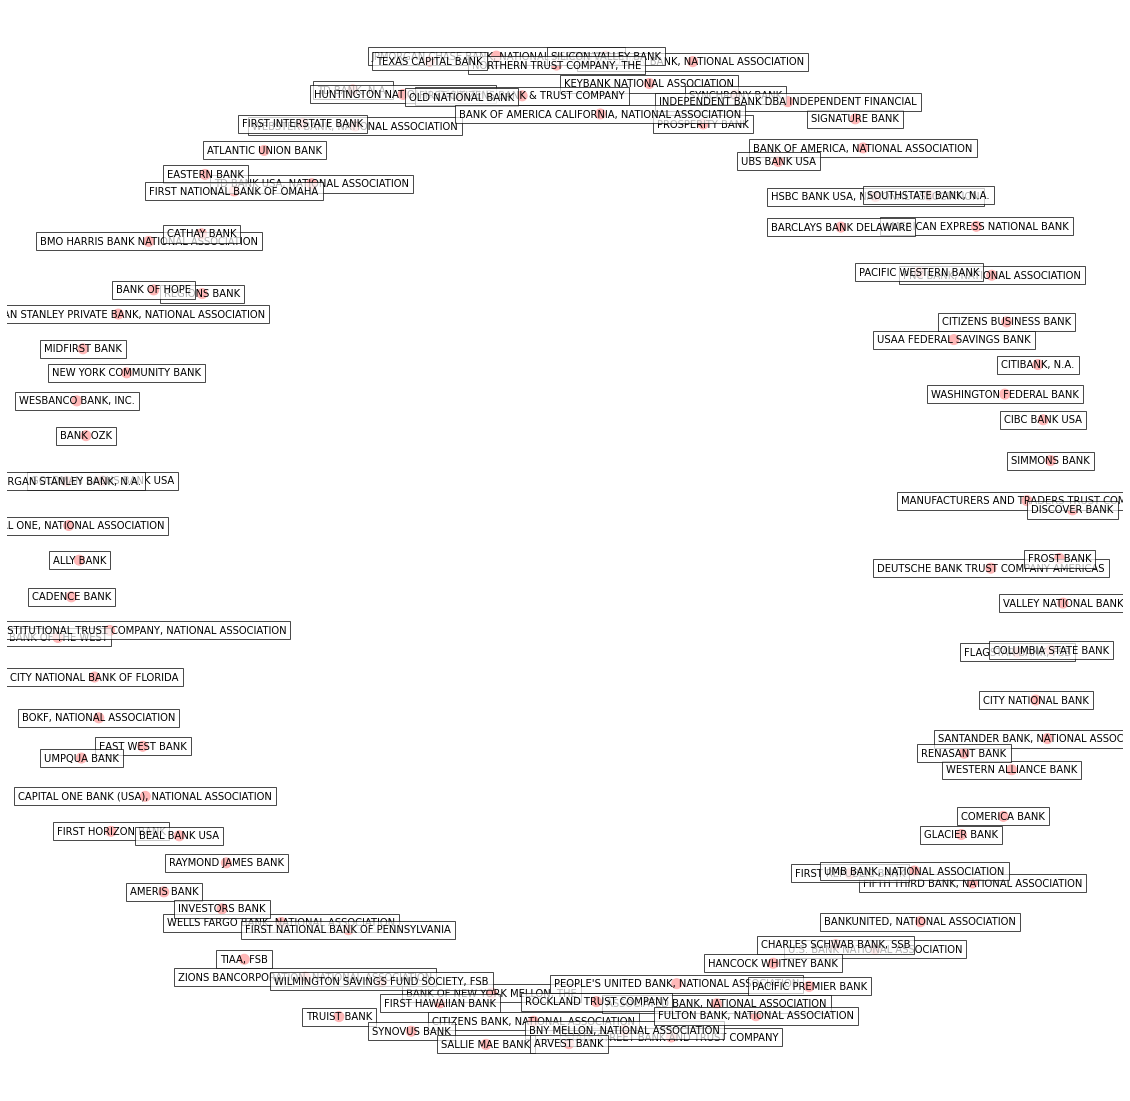

Step:  1000


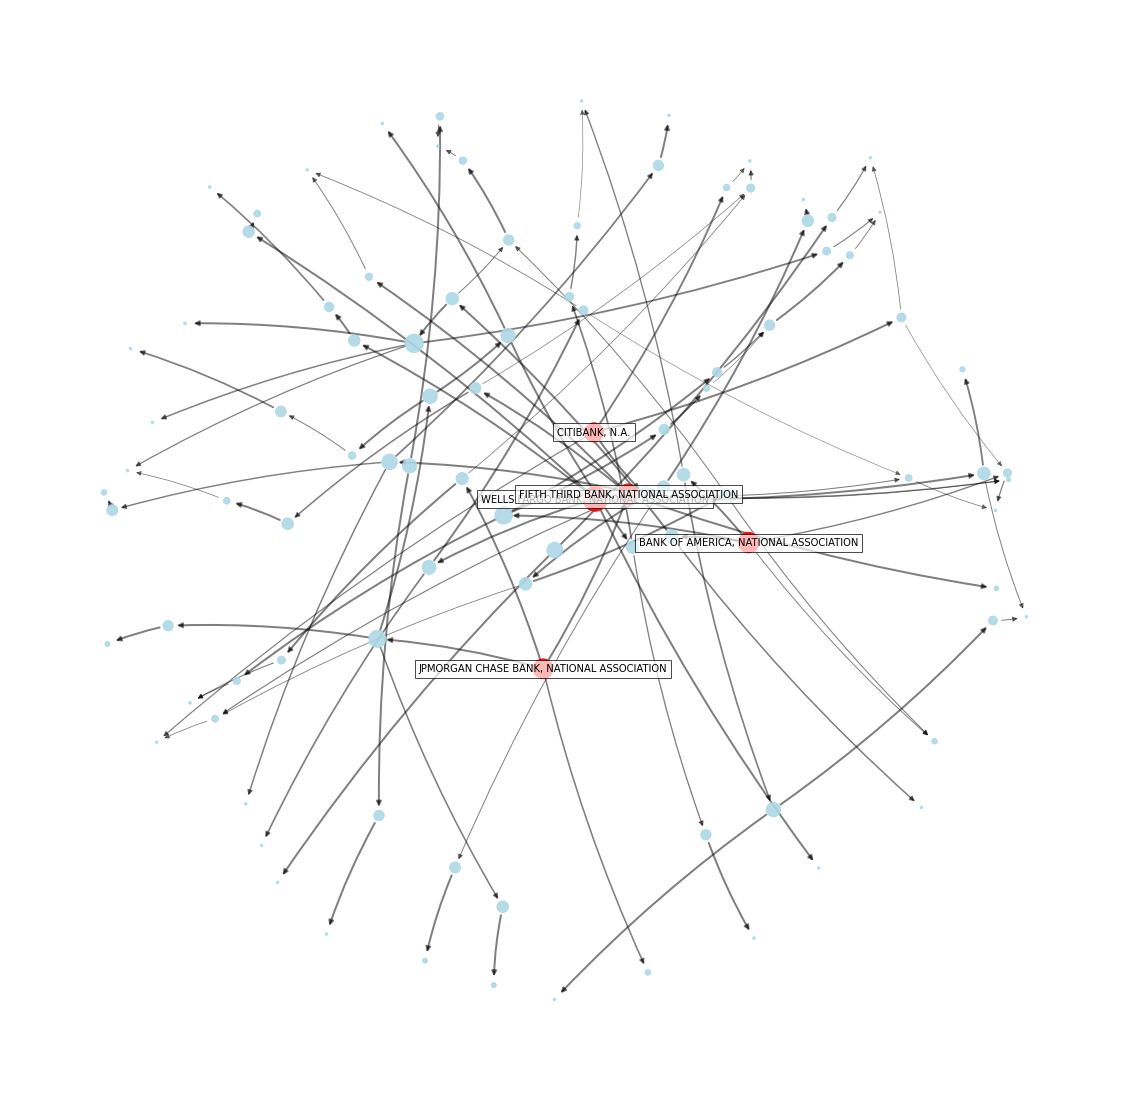

Step:  2000


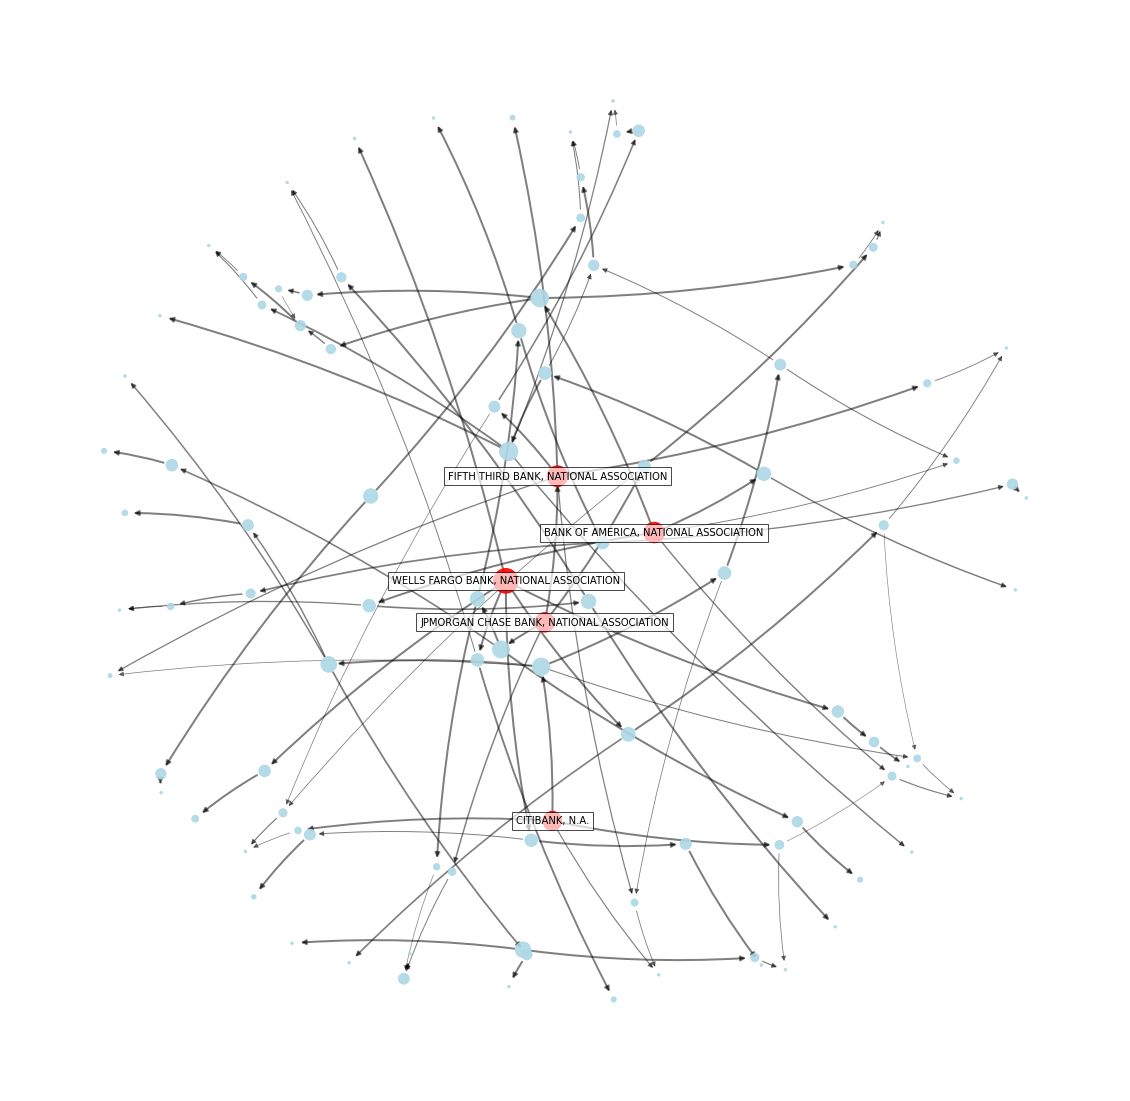

Step:  3000


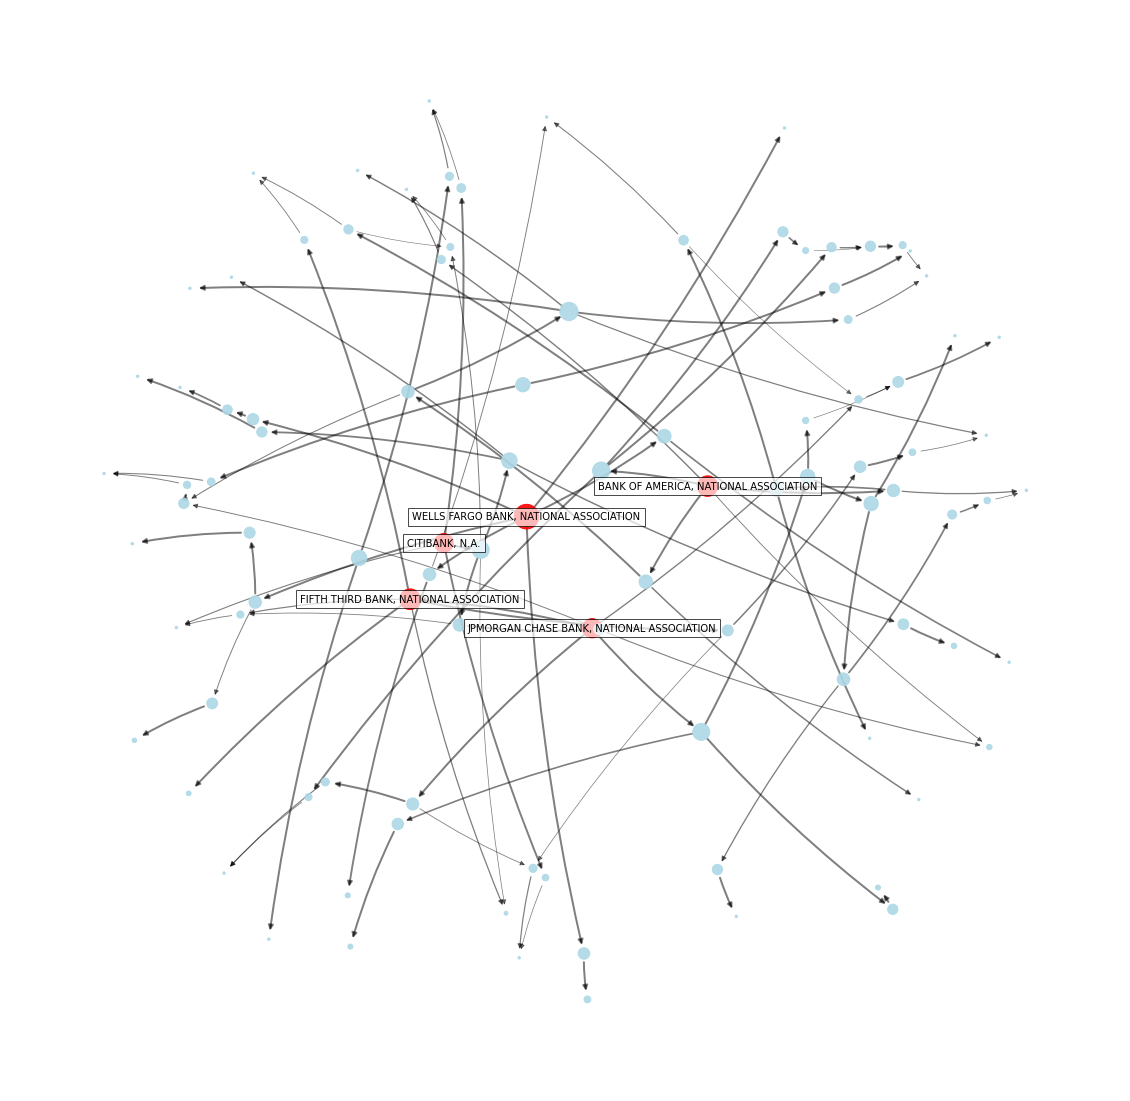

Step:  4000


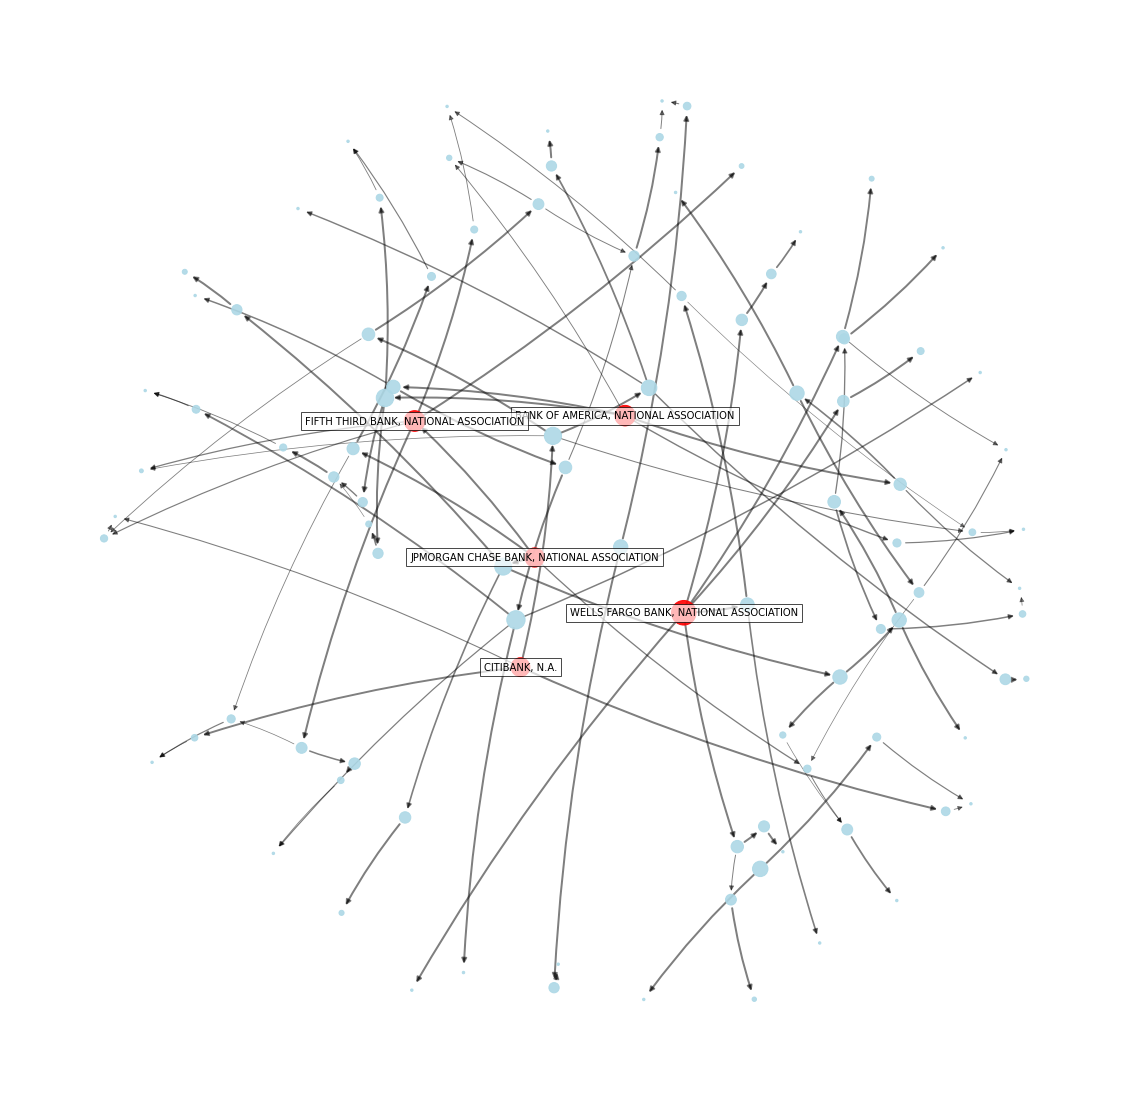

Step:  5000


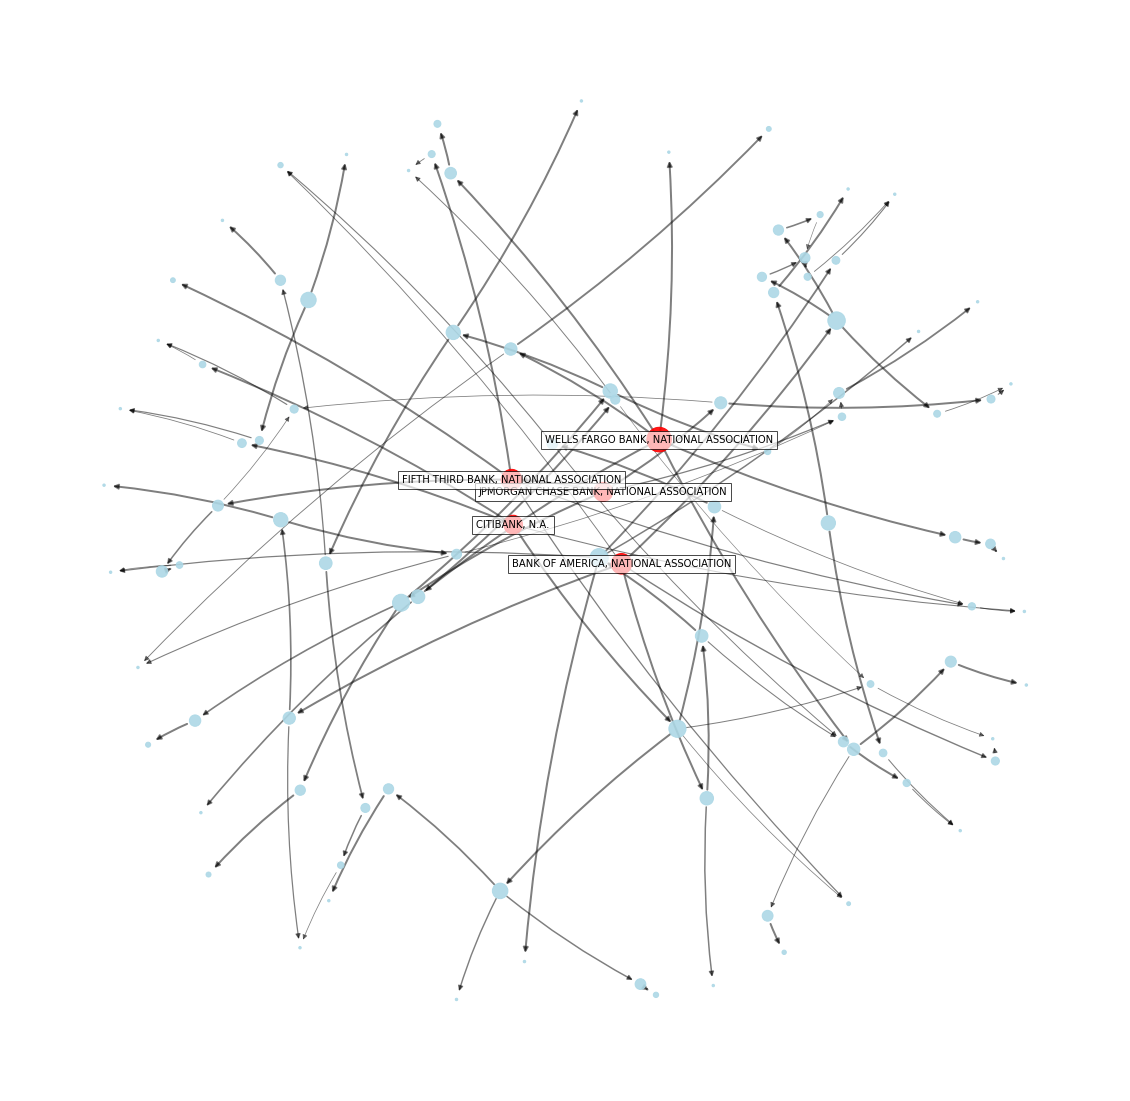

Step:  6000


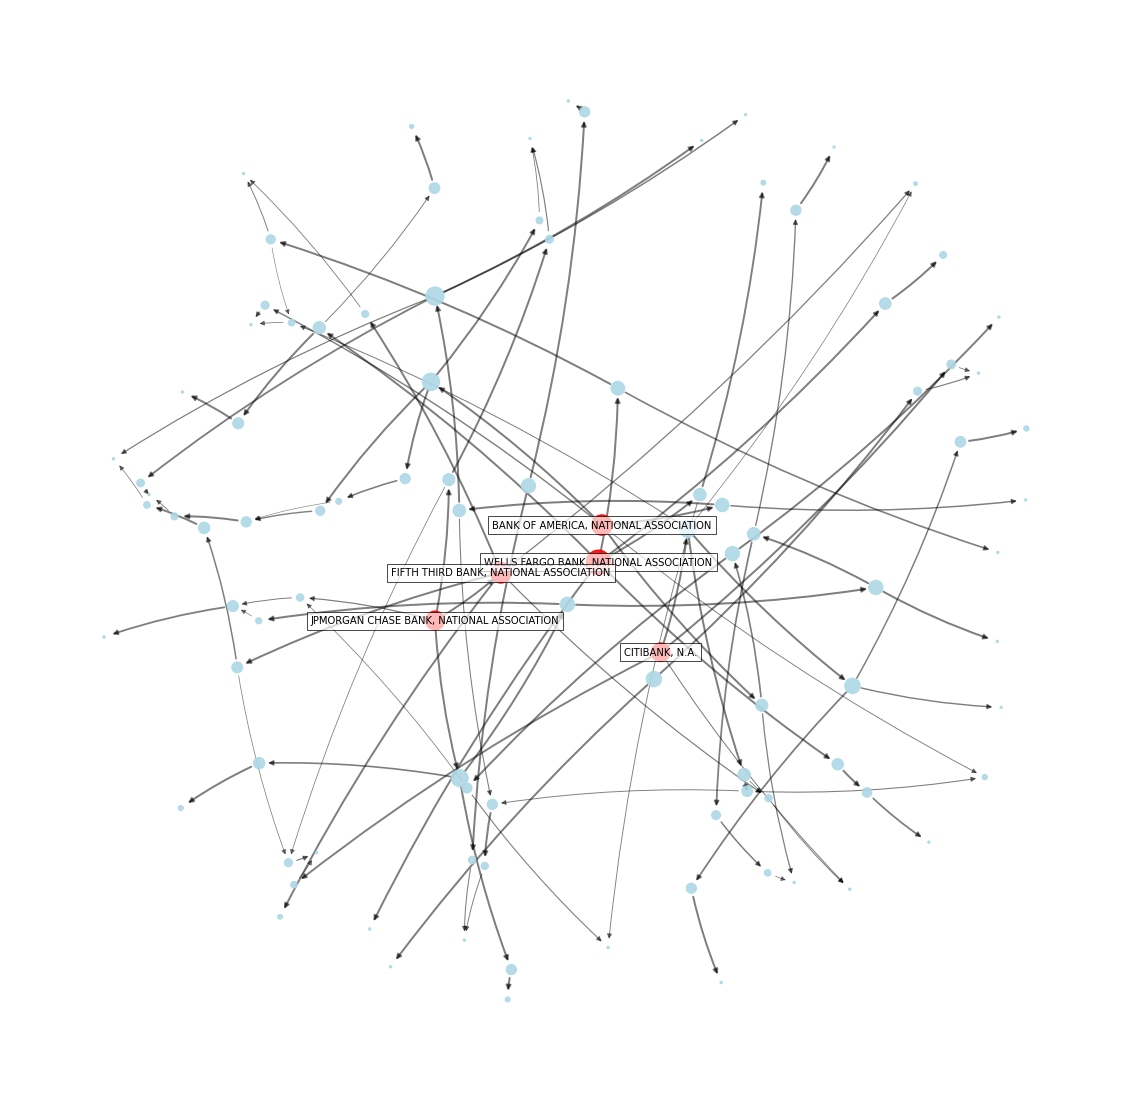

Step:  7000


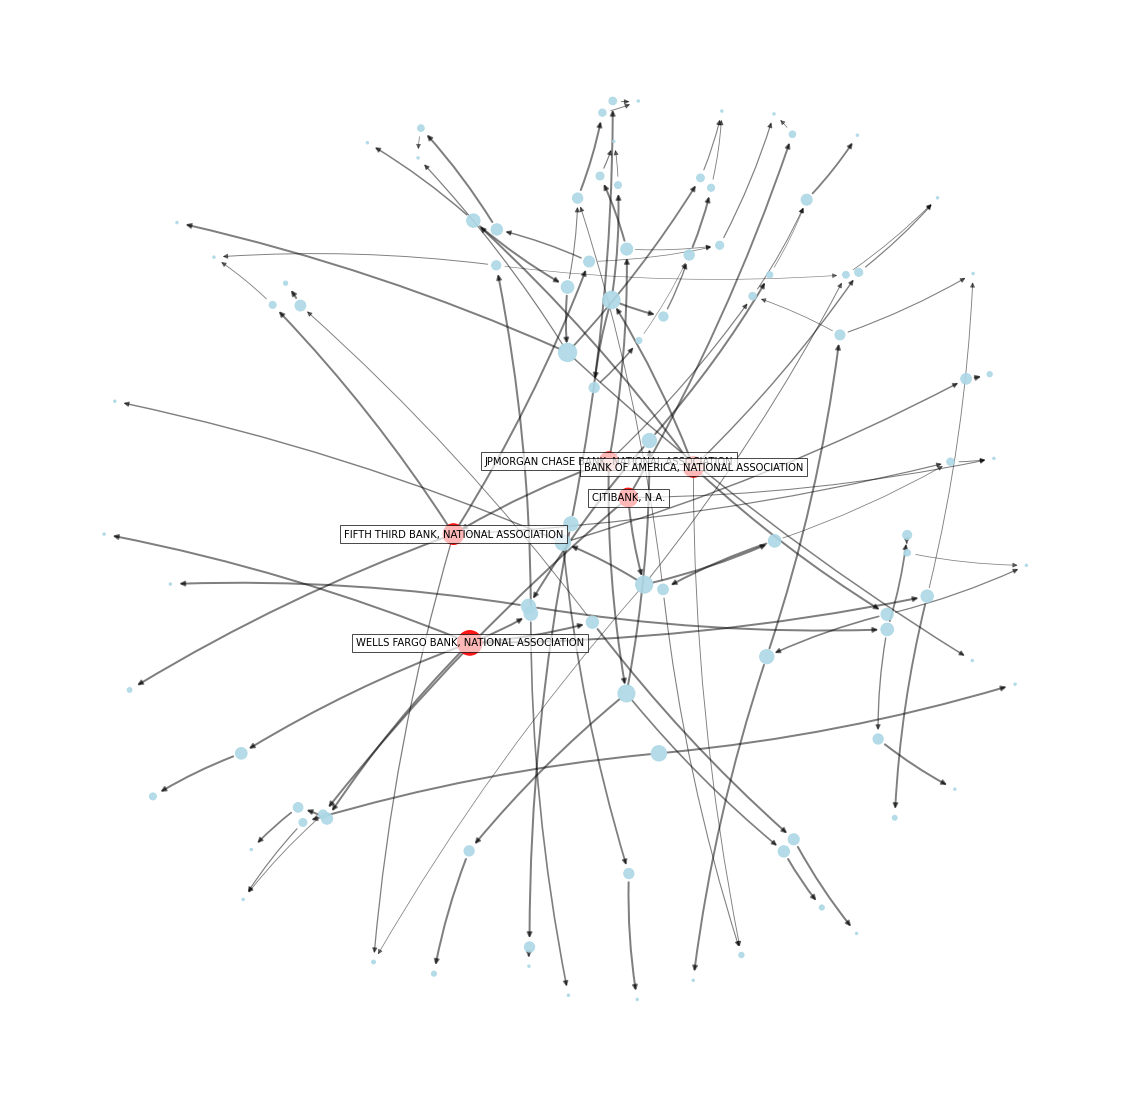

Step:  8000


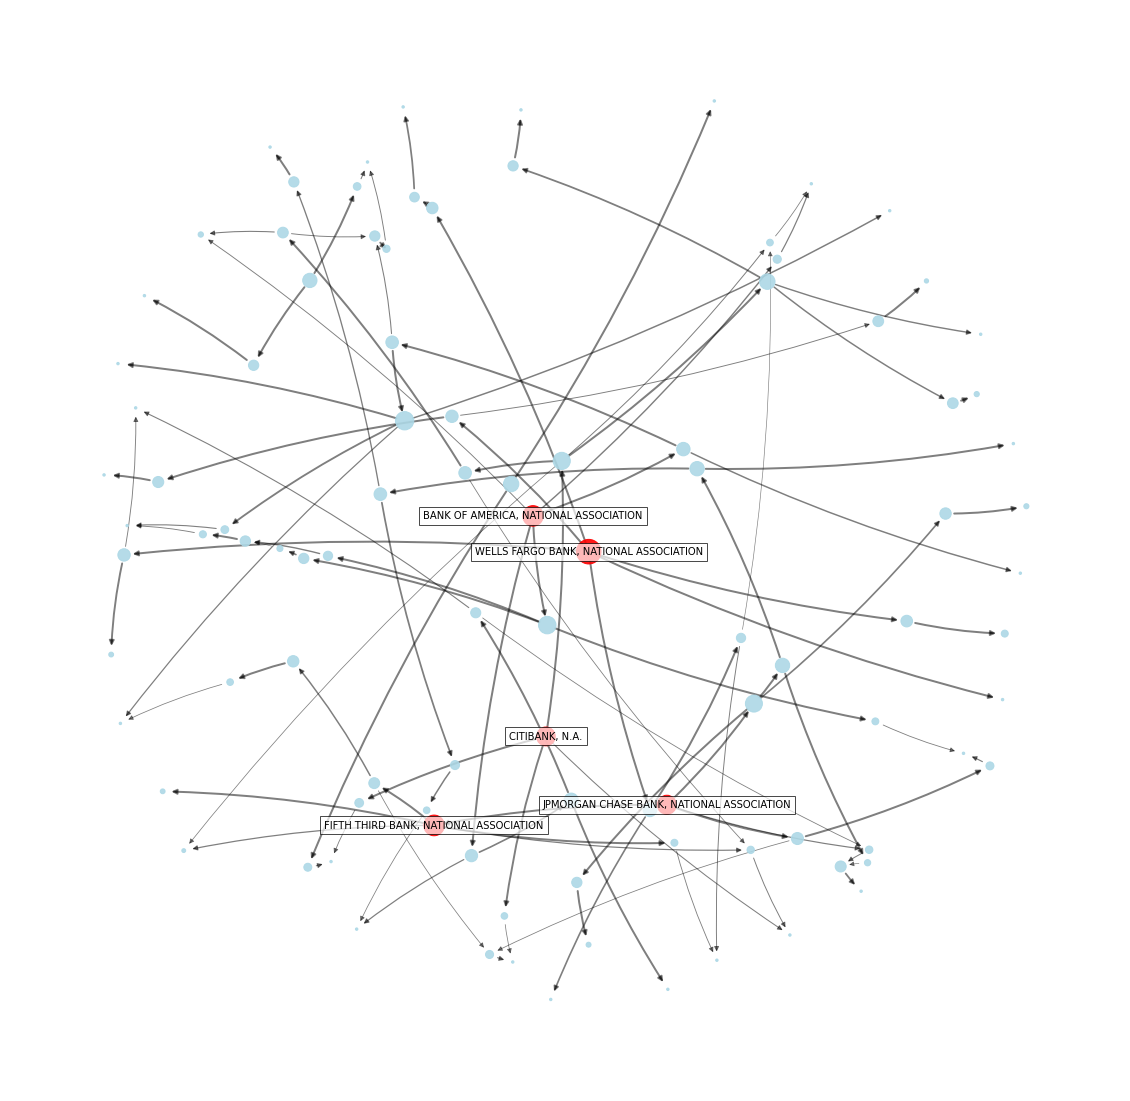

Step:  9000


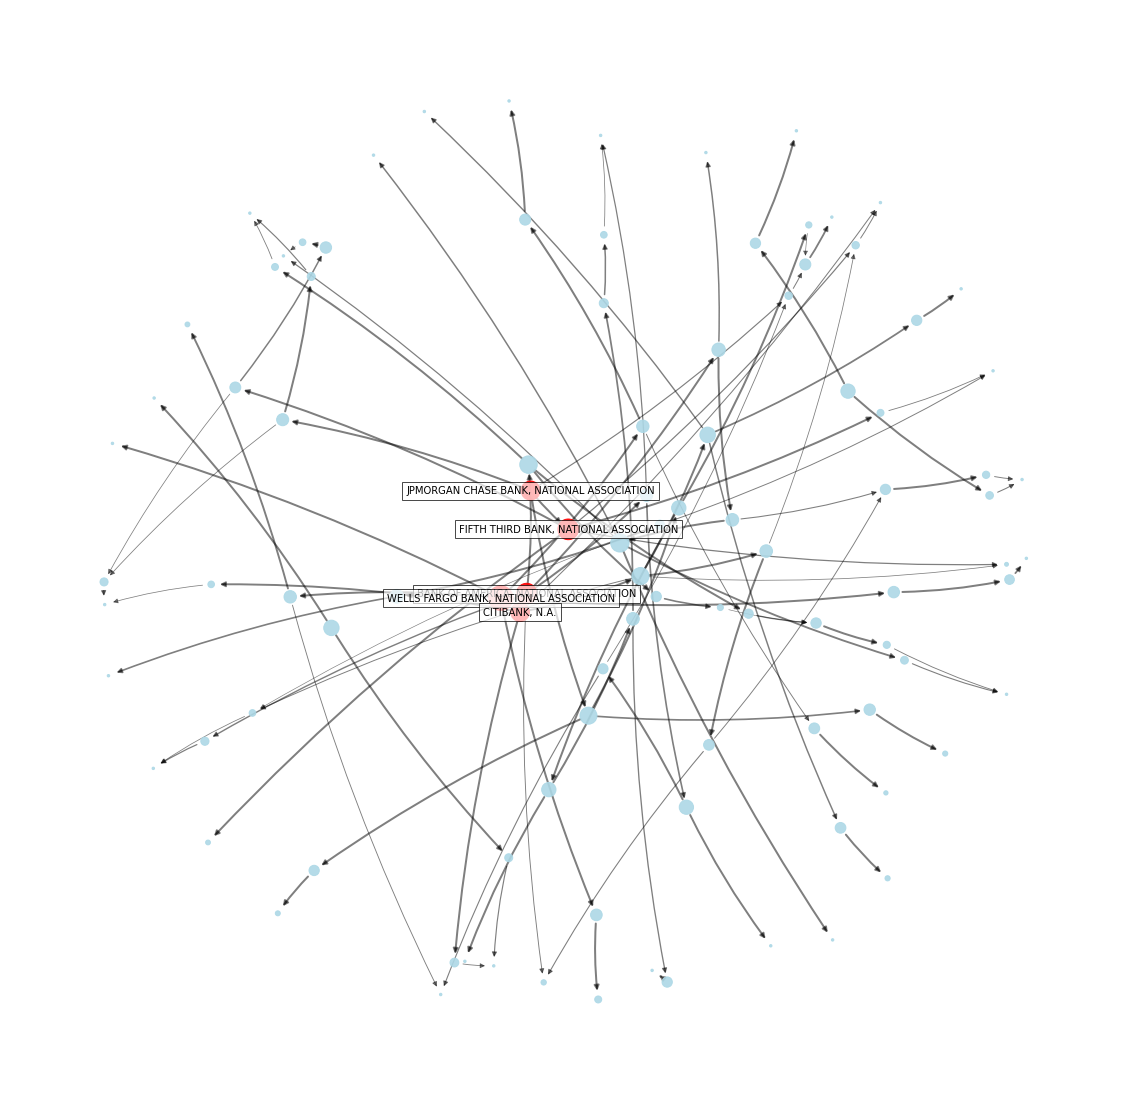

In [3]:
# create network graph
def netWorkGraph(matrix, model=model):
    size = model.N
    # Create a graph object with 5 nodes
    G = nx.DiGraph(seed=1)
    G.add_nodes_from(list(range(size)))
    # Create a list of edge weights
    weightedEdges = []
    for i in range(size):
        for j in range(size):
            if matrix[i][j] > 0.3:
                # direction of the edge is the direction of the money flow
                weightedEdges.append((j, i, matrix[i][j]))
    G.add_weighted_edges_from(weightedEdges)
    nodeSize = matrix.sum(axis=0) * 100 
    bigLabelIndex = np.where(nodeSize >= np.percentile(nodeSize, 95))[0]
    bigLabel = [model.banks[i] if i in bigLabelIndex else "" for i in range(size)]
    # Set the labels for the nodes using a list of variables
    label_dict = {node: label for node, label in zip(G.nodes, bigLabel)}
    edges = G.edges()
    edgesWidth = [G[u][v]['weight'] * 2 for u,v in edges]
    # change the color of the center nodes
    node_colors = ['red' if node in bigLabelIndex else 'lightblue' for node in G.nodes()]
    pos = nx.fruchterman_reingold_layout(G, scale=10)
    nx.draw_networkx_nodes(G, pos, node_size=nodeSize,node_color=node_colors, alpha=0.9)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos,labels = label_dict,
                            font_size=10, bbox=label_options)
    nx.draw_networkx_edges(G, pos, width=edgesWidth, alpha=0.5, connectionstyle="arc3,rad=0.05")
    plt.axis('off')
    plt.show()
    
for i in range(0, simulationSteps, simulationSteps//10):
    print("Step: ", i)
    trustMatrix = model_data["Trust Matrix"].iloc[i]
    netWorkGraph(matrix=trustMatrix)

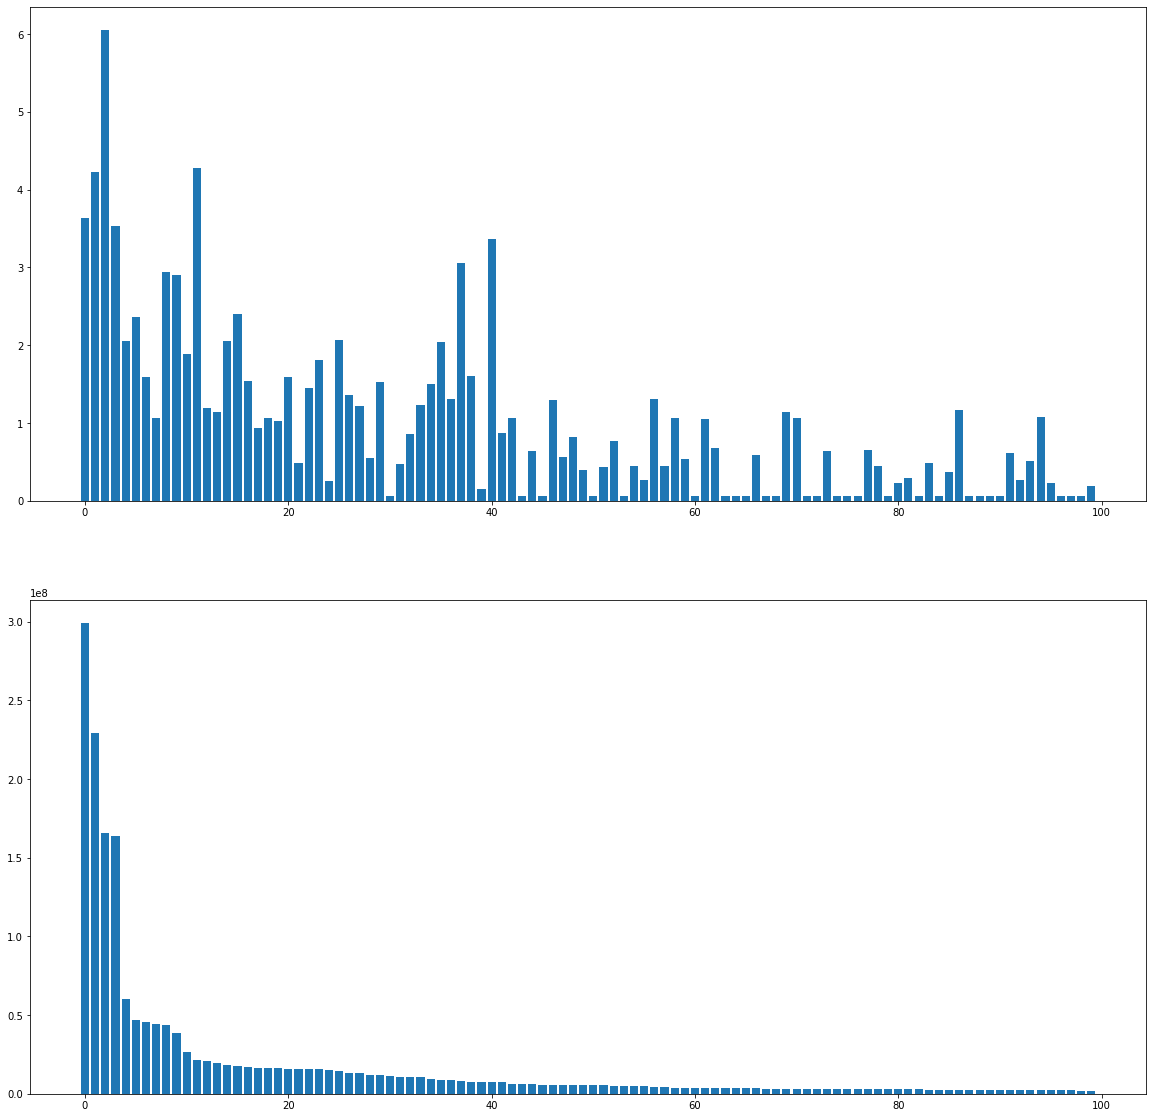

In [4]:
# bar chart of portfolio value
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(range(model.N), trustMatrix.sum(axis = 0))
ax2.bar(range(model.N), agent_data.xs(0, level="Step")["Equity"])
plt.show()

In [5]:
model.banks[:10]

0    JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
1        BANK OF AMERICA, NATIONAL ASSOCIATION
2       WELLS FARGO BANK, NATIONAL ASSOCIATION
3                               CITIBANK, N.A.
4                                  TRUIST BANK
5               PNC BANK, NATIONAL ASSOCIATION
6               U.S. BANK NATIONAL ASSOCIATION
7                                TD BANK, N.A.
8                       GOLDMAN SACHS BANK USA
9            CAPITAL ONE, NATIONAL ASSOCIATION
Name: bank, dtype: object